In [1]:
import torch
import os
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

In [2]:
class DatasetSign(Dataset):
    def __init__(self,root: str, name_dataset: str, transform=None):
        self.root = root
        self.transform = transform
        
        self.dir = self.root + 2*name_dataset
        self.data = []
        self.labels = []
        self._load_data()
        
    def _load_data(self):
        self.folder = glob(self.dir + "/*/")
        for index in self.folder:
            index_path = os.path.join(index)
            if os.path.isdir(index_path):
                for img_name in os.listdir(index_path):
                    img_path = os.path.join(index_path, img_name)
                    if 'original' in img_name or 'G' in img_name:
                        self.data.append(img_path)
                        self.labels.append(1)  # 1 cho chữ ký thật
                    elif 'forgeries' in img_name or 'F' in img_name:
                        self.data.append(img_path)
                        self.labels.append(0)  # 0 cho chữ ký giả
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('L')  # Chuyển sang grayscale
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
class DataSign2(DatasetSign):
    def __init__(self, root: str, name_dataset: str, transform=None):
        self.root = root
        self.transform = transform

        self.dir = os.path.join(self.root, name_dataset)
        # print(self.dir)
        self.data = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        # print(self.dir)
        self.folder = glob(os.path.join(self.dir, "*/"))
        # print(self.folder)
        for index in self.folder:
            # print(index)
            index_path = os.path.join(index)
            # print(index_path)
            if os.path.isdir(index_path):
                for img_name in os.listdir(index_path):
                    img_path = os.path.join(index_path, img_name)
                    # print(img_path)
                    if 'FORGED' in index_path:
                        self.data.append(img_path)
                        self.labels.append(0)  # 0 cho chữ ký giả
                    if 'GENUINE' in index_path:
                        self.data.append(img_path)
                        self.labels.append(1)  # 1 cho chữ ký thật

In [4]:
# datasign = DatasetSign(root='/kaggle/input/handwritten-signature-datasets', name_dataset='/CEDAR')
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Thay đổi kích thước ảnh
    transforms.CenterCrop((64,64)),
    transforms.ToTensor(),  # Chuyển ảnh thành tensor
    transforms.Normalize((0.5,), (0.5,))  # Chuẩn hóa ảnh
])

dataset1 = DatasetSign(root='dataset/archive (1)/', name_dataset='/CEDAR', transform=transform)
dataset2 = DatasetSign(root='dataset/archive (1)/', name_dataset='/BHSig260-Hindi', transform=transform)
dataset3 = DatasetSign(root='dataset/archive (1)/', name_dataset='/BHSig260-Bengali', transform=transform)
len(dataset1),len(dataset2),len(dataset3)

(2640, 8640, 5400)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Khởi tạo mô hình



In [6]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
# num_epochs = 10
batch_size = 64
print(device)

cuda


In [7]:
# Trực quan hóa các thông số metric với seaborn
def visualize_metrics_seaborn(metrics):
    metrics_names = list(metrics.keys())
    metrics_values = list(metrics.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Evaluation Metrics')
    plt.ylim([0, 1])
    
    # Hiển thị giá trị trên các cột
    for i, value in enumerate(metrics_values):
        plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    plt.show()

In [8]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prediction')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [9]:
def plot_roc_curve(fpr, tpr, roc_auc, optimal_idx, optimal_threshold):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Optimal threshold = %0.2f' % optimal_threshold)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.show()

In [10]:


def evaluate_model(discriminator, test_loader, device):
    all_labels = []
    all_predictions = []
    discriminator.eval()  # Đặt mô hình ở chế độ đánh giá
    with torch.no_grad():  # Tắt tính toán gradient cho quá trình đánh giá
        for real_images, labels in test_loader:
            real_images = real_images.to(device)
            labels = labels.to(device).float()
            
            outputs = discriminator(real_images).view(-1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())
    
    # Tính toán ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)
    
    # Tìm ngưỡng giá trị tối ưu
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Vẽ ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Optimal threshold = %0.2f' % optimal_threshold)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    all_predictions = [1 if x > optimal_threshold else 0 for x in all_predictions]

    classification_report_result = classification_report(all_labels, all_predictions)
    print(classification_report_result)
    
    # Tính toán và lưu lại classification report dưới dạng từ điển
    classification_report_dict = classification_report(all_labels, all_predictions, output_dict=True)
    # print(classification_report_dict)
    
    # Nếu bạn chỉ muốn lưu các thông số chính như precision, recall, f1-score, accuracy
    metrics = {
        "accuracy": classification_report_dict["accuracy"],
        "precision": classification_report_dict["0.0"]["precision"],
        "recall": classification_report_dict["0.0"]["recall"],
        "f1-score": classification_report_dict["0.0"]["f1-score"]
    }
    
    # print(metrics)
    visualize_metrics_seaborn(metrics)

    # Đặt mô hình trở lại chế độ huấn luyện
    discriminator.train()

    return all_labels, all_predictions, optimal_threshold, metrics

# Đánh giá mô hình sau khi huấn luyện
# all_labels, all_predictions, optimal_threshold, classification_report_dict, metrics = evaluate_model(discriminator, test_loader, device)


In [11]:
def train_dcgan(generator, discriminator, train_loader, epochs, device, criterion, optimizerD, optimizerG):
    G_losses = []
    D_losses = []
    for epoch in range(epochs):
        for i, (real_images, labels) in enumerate(train_loader):
            batch_size = real_images.size(0)
            fake_labels = torch.zeros(batch_size).to(device)
            real_labels = torch.ones(batch_size).to(device)

            # Huấn luyện Discriminator
            discriminator.zero_grad()
            real_images = real_images.to(device)
            labels = labels.to(device).float()
            outputs = discriminator(real_images).view(-1)
            d_loss_real = criterion(outputs, labels)
            d_loss_real.backward()
            # optimizerD.step()

            z = torch.randn(batch_size, 100, 1, 1).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach()).view(-1)
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            d_loss = d_loss_real + d_loss_fake
            optimizerD.step()

            generator.zero_grad()
            output = discriminator(fake_images).view(-1)
            g_loss = criterion(output, real_labels)
            g_loss.backward()
            optimizerG.step()
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())

            print(f"Epoch [{epoch+1}/{epochs}] Batch {i+1}/{len(train_loader)} Loss D: {d_loss.item()} Loss G: {g_loss.item()}")

    return generator, discriminator, G_losses, D_losses


    

### Train on CEDAR, BHSig260-Hindi, BHSig260-Bengali Dataset

Training on CEDAR
Epoch [1/10] Batch 1/33 Loss D: 1.3970881700515747 Loss G: 4.1927080154418945
Epoch [1/10] Batch 2/33 Loss D: 0.6557354927062988 Loss G: 3.3155317306518555
Epoch [1/10] Batch 3/33 Loss D: 0.4748569130897522 Loss G: 4.475533485412598
Epoch [1/10] Batch 4/33 Loss D: 0.1374191790819168 Loss G: 5.073102951049805
Epoch [1/10] Batch 5/33 Loss D: 0.08250173181295395 Loss G: 5.284224033355713
Epoch [1/10] Batch 6/33 Loss D: 0.05418786779046059 Loss G: 5.498068332672119
Epoch [1/10] Batch 7/33 Loss D: 0.041600991040468216 Loss G: 5.5736236572265625
Epoch [1/10] Batch 8/33 Loss D: 0.037808556109666824 Loss G: 5.5723981857299805
Epoch [1/10] Batch 9/33 Loss D: 0.05067688599228859 Loss G: 5.572736740112305
Epoch [1/10] Batch 10/33 Loss D: 0.03858562931418419 Loss G: 5.795341491699219
Epoch [1/10] Batch 11/33 Loss D: 0.02558530680835247 Loss G: 6.0122175216674805
Epoch [1/10] Batch 12/33 Loss D: 0.0221109576523304 Loss G: 6.2728447914123535
Epoch [1/10] Batch 13/33 Loss D: 0.02945

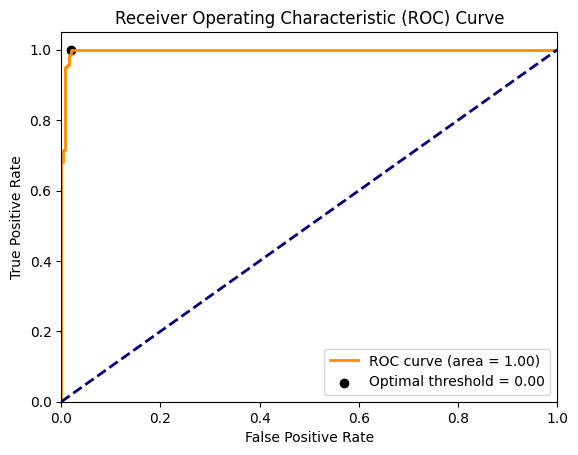

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       259
         1.0       0.98      1.00      0.99       269

    accuracy                           0.99       528
   macro avg       0.99      0.99      0.99       528
weighted avg       0.99      0.99      0.99       528



C:\Users\TanLoc\AppData\Local\Temp\ipykernel_9692\337143034.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')


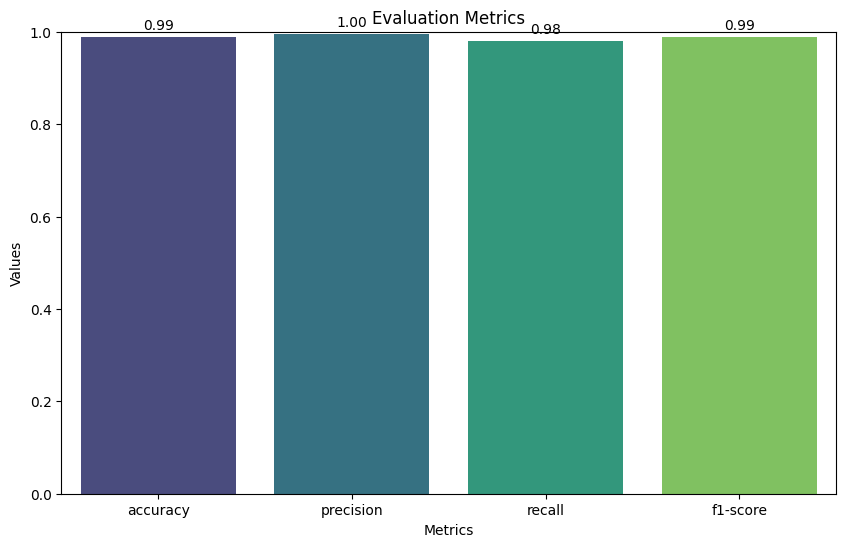

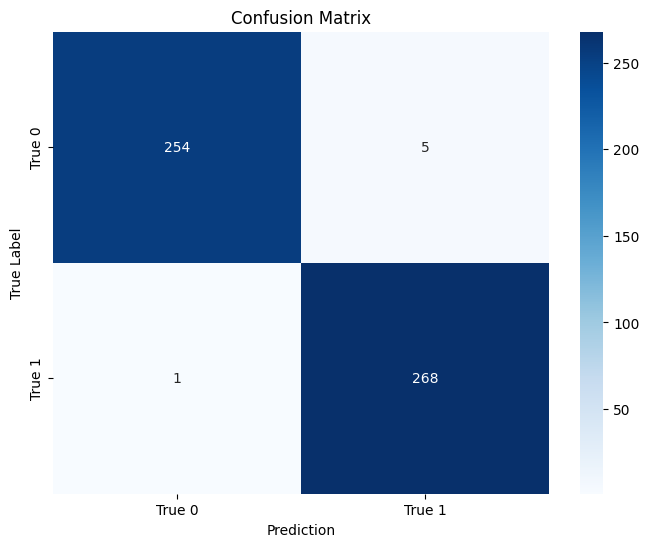

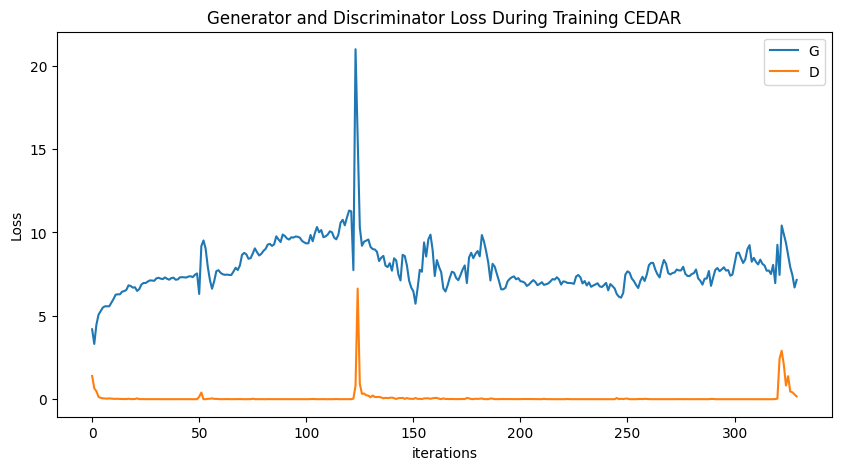

Training on BHSig260-Hindi
Epoch [1/10] Batch 1/108 Loss D: 1.5301711559295654 Loss G: 4.394920825958252
Epoch [1/10] Batch 2/108 Loss D: 1.276537299156189 Loss G: 3.2779600620269775
Epoch [1/10] Batch 3/108 Loss D: 1.0878758430480957 Loss G: 4.241672992706299
Epoch [1/10] Batch 4/108 Loss D: 0.9432468414306641 Loss G: 4.485308647155762
Epoch [1/10] Batch 5/108 Loss D: 0.743790864944458 Loss G: 4.1989665031433105
Epoch [1/10] Batch 6/108 Loss D: 0.7504879236221313 Loss G: 4.759799003601074
Epoch [1/10] Batch 7/108 Loss D: 0.5681144595146179 Loss G: 5.320785999298096
Epoch [1/10] Batch 8/108 Loss D: 0.6423484683036804 Loss G: 5.163643836975098
Epoch [1/10] Batch 9/108 Loss D: 0.7895755767822266 Loss G: 4.761505126953125
Epoch [1/10] Batch 10/108 Loss D: 0.68328458070755 Loss G: 5.809843063354492
Epoch [1/10] Batch 11/108 Loss D: 0.6119843125343323 Loss G: 5.514823913574219
Epoch [1/10] Batch 12/108 Loss D: 0.6870744824409485 Loss G: 5.219316482543945
Epoch [1/10] Batch 13/108 Loss D: 0.

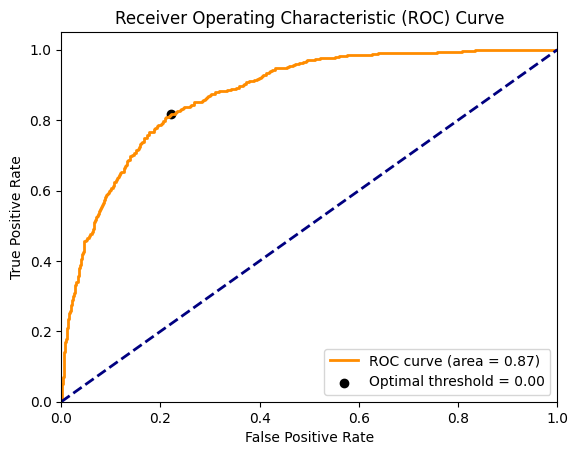

              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       962
         1.0       0.75      0.82      0.78       766

    accuracy                           0.80      1728
   macro avg       0.79      0.80      0.79      1728
weighted avg       0.80      0.80      0.80      1728



C:\Users\TanLoc\AppData\Local\Temp\ipykernel_9692\337143034.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')


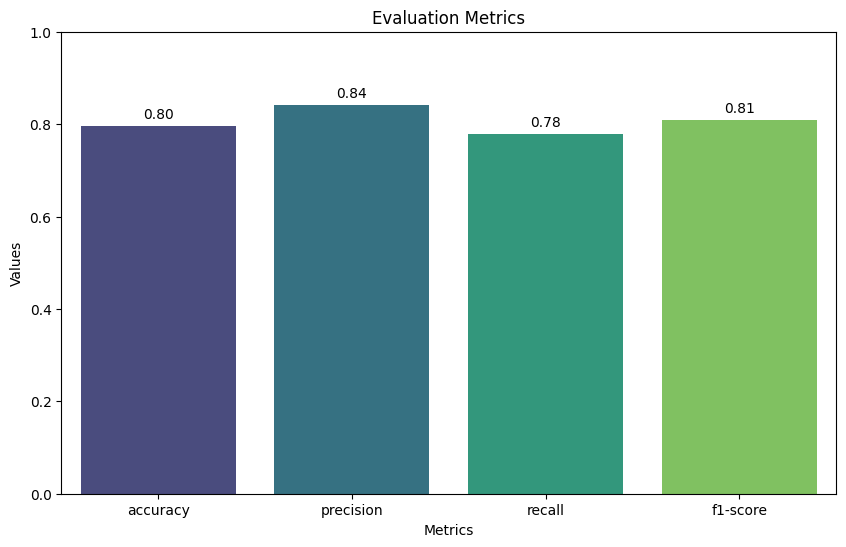

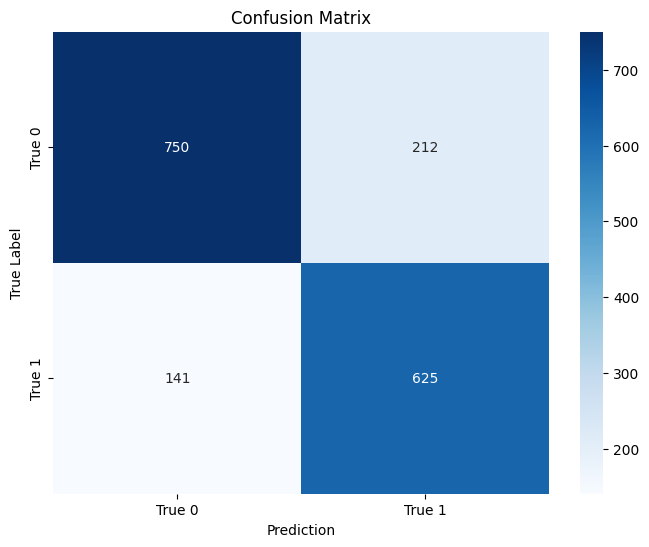

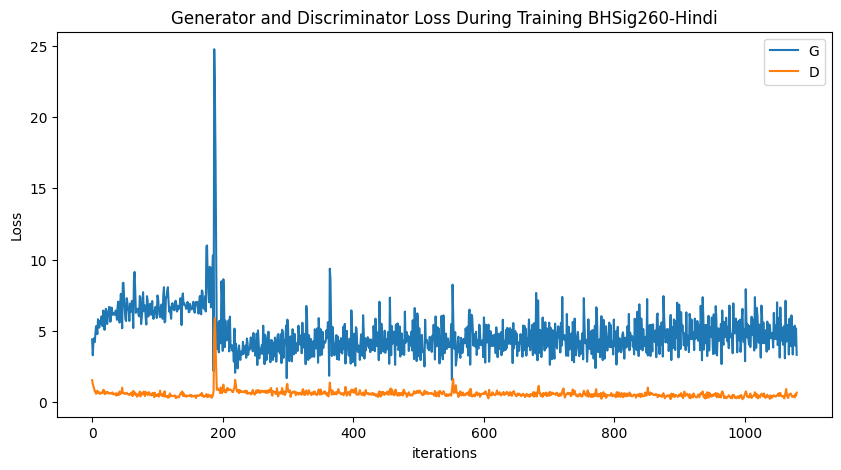

Training on BHSig260-Bengali
Epoch [1/10] Batch 1/68 Loss D: 1.5015734434127808 Loss G: 4.370333194732666
Epoch [1/10] Batch 2/68 Loss D: 1.4590213298797607 Loss G: 3.709524631500244
Epoch [1/10] Batch 3/68 Loss D: 0.8776203989982605 Loss G: 3.8213188648223877
Epoch [1/10] Batch 4/68 Loss D: 1.0966672897338867 Loss G: 5.007526397705078
Epoch [1/10] Batch 5/68 Loss D: 0.6865115165710449 Loss G: 5.1082563400268555
Epoch [1/10] Batch 6/68 Loss D: 0.6812650561332703 Loss G: 4.6656694412231445
Epoch [1/10] Batch 7/68 Loss D: 0.6577726006507874 Loss G: 5.255717754364014
Epoch [1/10] Batch 8/68 Loss D: 0.590528130531311 Loss G: 5.389519691467285
Epoch [1/10] Batch 9/68 Loss D: 0.5687596201896667 Loss G: 5.261582851409912
Epoch [1/10] Batch 10/68 Loss D: 0.5434189438819885 Loss G: 5.56954288482666
Epoch [1/10] Batch 11/68 Loss D: 0.7125278115272522 Loss G: 5.416298866271973
Epoch [1/10] Batch 12/68 Loss D: 0.7258158326148987 Loss G: 5.714259147644043
Epoch [1/10] Batch 13/68 Loss D: 0.62823581

In [ ]:
datasets = [('CEDAR', dataset1), ('BHSig260-Hindi', dataset2), ('BHSig260-Bengali', dataset3)]

generators = []
discriminators = []
metrics = []
classification_reports = []

for dataset_name, dataset in datasets:
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    criterion = torch.nn.BCELoss()
    optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f'Training on {dataset_name}')
    generator, discriminator, g_loss, d_loss = train_dcgan(generator, discriminator, train_loader, num_epochs, device, criterion, optimizerD, optimizerG)
    labels, predictions, optimal_threshold, metric = evaluate_model(discriminator, test_loader, device)

    generators.append(generator)
    discriminators.append(discriminator)
    metrics.append((dataset_name, metric))
    classification_reports.append((dataset_name, labels, predictions, optimal_threshold))
    cm = confusion_matrix(labels, predictions)
    plot_confusion_matrix(cm, class_names=['True 0', 'True 1'])
    
    plt.figure(figsize=(10,5))
    plt.title(f"Generator and Discriminator Loss During Training {dataset_name}")
    plt.plot(g_loss,label="G")
    plt.plot(d_loss,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


### Train on SigComp Dataset

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = torch.nn.BCELoss()
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

train_dataset = DataSign2(root='dataset/data', name_dataset='train', transform=transform)
test_dataset = DataSign2(root='dataset/data', name_dataset='test', transform=transform)

# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training on SigComp')
generator, discriminator, d_loss, g_loss = train_dcgan(generator, discriminator, train_loader, num_epochs, device, criterion, optimizerD, optimizerG)
labels, predictions, optimal_threshold, metric = evaluate_model(discriminator, test_loader, device)

generators.append(generator)
discriminators.append(discriminator)
metrics.append(('SigComp', metric))
classification_reports.append(('SigComp', labels, predictions, optimal_threshold))
cm = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm, class_names=['True 0', 'True 1'])

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training SigComp")
plt.plot(g_loss,label="G")
plt.plot(d_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
for dataset_name, metric in metrics:
    print(f'Results for {dataset_name}:')
    print(visualize_metrics_seaborn(metric))